# MrBourkeYoutubeStats.ipynb

## Let me tell you a story...
We are going to explore [Daniel Bourke's youtube channel](https://www.youtube.com/channel/UCr8O8l5cCX85Oem1d18EezQ "mrdbourke").

Specfically, we are going to look at the different types of videos he has for who. His videos seem to follow two broad topics: machine learning for what he is known for and health and fitness.

I want to look at the popularity based on number of views of his machine learning orientated videos compared to his fitness and health related videos.

## Aims
- Pull data from youtube API

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as r

%matplotlib inline

import os
import requests
import json
import math
import re

from datetime import date, time, datetime

import googleapiclient.discovery
import googleapiclient.errors

In [2]:
%run setAPIkey.py

In [3]:
API_KEY = os.getenv('YT_API')

In [4]:
api_service_name = 'youtube'
api_version = 'v3'
youtube = googleapiclient.discovery.build(api_service_name, api_version, developerKey=API_KEY)

In [5]:
channel_ID = 'UCr8O8l5cCX85Oem1d18EezQ' # Daniel Bourke's channel ID

channel_request = youtube.channels().list(
    part='snippet,contentDetails',
    id=channel_ID
)
channel_res = channel_request.execute()
#channel_res

In [6]:
uploadPlaylist_ID = channel_res['items'][0]['contentDetails']['relatedPlaylists']['uploads']
#print('Upload Playlist ID: ' + uploadPlaylist_ID)

In [7]:
def playlist_requester(pageToken=None,uploadPlaylist_ID=uploadPlaylist_ID):
    playlist_request = youtube.playlistItems().list(
        part='snippet,contentDetails',
        maxResults=50,
        pageToken=pageToken,
        playlistId=uploadPlaylist_ID
    )
    playlist_res = playlist_request.execute()
    
    return playlist_res

playlist_res = playlist_requester()

In [8]:
TOTAL_UPLOADS = playlist_res['pageInfo']['totalResults']
nextPageToken = playlist_res['nextPageToken']
#print(TOTAL_UPLOADS, nextPageToken)

listOfVideo_IDs = [ video_ID['contentDetails']['videoId'] for video_ID in playlist_res['items'] ] # first 50
print(len(listOfVideo_IDs))
#listOfVideo_IDs

50


In [9]:
while TOTAL_UPLOADS > len(listOfVideo_IDs):
    
    # going through pages and extending list of video IDs
    
    nextpage_playlist_res = playlist_requester(nextPageToken)
    listOfVideo_IDs.extend([ video_ID['contentDetails']['videoId'] for video_ID in nextpage_playlist_res['items'] 
                            if video_ID['contentDetails']['videoId'] not in listOfVideo_IDs ]) # extend() for lists / #append only does one item at ta time / concating lists with + is very intenstive according to "Python for Data Analysis"
    if 'nextPageToken' in nextpage_playlist_res:
        nextPageToken = nextpage_playlist_res['nextPageToken']
    print('Number of Uploaded Videos: ' + str(len(listOfVideo_IDs)))
    #print(nextPageToken)

Number of Uploaded Videos: 100
Number of Uploaded Videos: 150
Number of Uploaded Videos: 200
Number of Uploaded Videos: 250
Number of Uploaded Videos: 251


In [10]:
df = pd.DataFrame()

for i in range(math.ceil(len(listOfVideo_IDs)/50)):
    video_request = youtube.videos().list(
        part='snippet,contentDetails,statistics',
        id=listOfVideo_IDs[50*i:50*(i+1)]
    )
    video_response = video_request.execute()

    sub_df = pd.json_normalize(video_response, 'items')
    frames = [df, sub_df]
    df = pd.concat(frames)

In [11]:
df.head(2)

,kind,etag,id,snippet.publishedAt,snippet.channelId,snippet.title,snippet.description,snippet.thumbnails.default.url,snippet.thumbnails.default.width,snippet.thumbnails.default.height,...,contentDetails.caption,contentDetails.licensedContent,contentDetails.projection,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.favoriteCount,statistics.commentCount,snippet.defaultAudioLanguage,contentDetails.regionRestriction.blocked
0,youtube#video,y1cecw31MFlW1LRZGdZ-T5Vex1s,3IKWukTiBfc,2020-08-09T06:06:03Z,UCr8O8l5cCX85Oem1d18EezQ,The future will not be supervised... | Machine...,This month has been all about GPT3 and self-su...,https://i.ytimg.com/vi/3IKWukTiBfc/default.jpg,120,90,...,false,True,rectangular,7088,271,1,0,35,NaN,NaN
1,youtube#video,5tD2U8xifujFsTFH38FXGSGEKao,8JTKX09LzNc,2020-08-06T00:29:48Z,UCr8O8l5cCX85Oem1d18EezQ,Are courses enough for a job? | Machine learni...,"Let's talk machine learning, health, business ...",https://i.ytimg.com/vi/8JTKX09LzNc/default.jpg,120,90,...,false,True,rectangular,7002,302,9,0,25,NaN,NaN


In [12]:
#checking dataframe
df.shape

(251, 41)

In [13]:
#exploring different columns
df.dtypes

kind                                         object
etag                                         object
id                                           object
snippet.publishedAt                          object
snippet.channelId                            object
snippet.title                                object
snippet.description                          object
snippet.thumbnails.default.url               object
snippet.thumbnails.default.width              int64
snippet.thumbnails.default.height             int64
snippet.thumbnails.medium.url                object
snippet.thumbnails.medium.width               int64
snippet.thumbnails.medium.height              int64
snippet.thumbnails.high.url                  object
snippet.thumbnails.high.width                 int64
snippet.thumbnails.high.height                int64
snippet.thumbnails.standard.url              object
snippet.thumbnails.standard.width           float64
snippet.thumbnails.standard.height          float64
snippet.thum

In [14]:
# contining with most relavant columns
df1 = df[['snippet.title', 'snippet.tags', 'contentDetails.duration',
       'statistics.viewCount', 'statistics.likeCount', 'statistics.dislikeCount',
        'statistics.commentCount', 'snippet.publishedAt']]
#df1.ix['statistics.viewCount'] = df1['statistics.viewCount'].astype('int')
df1.head()

,snippet.title,snippet.tags,contentDetails.duration,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.commentCount,snippet.publishedAt
0,The future will not be supervised... | Machine...,"[self supervised learning machine learning, ma...",PT26M28S,7088,271,1,35,2020-08-09T06:06:03Z
1,Are courses enough for a job? | Machine learni...,NaN,PT1H24M11S,7002,302,9,25,2020-08-06T00:29:48Z
2,What does a head of data science look for in a...,"[ken jee, daniel bourke, what questions get as...",PT1H1M6S,9081,450,8,34,2020-07-16T03:15:13Z
3,2020 Machine Learning Roadmap,"[machine learning field guide, machine learnin...",PT2H37M14S,229860,12237,140,524,2020-07-12T15:00:12Z
4,One Neural Network to Rule Them All (and more)...,"[zero to mastery, machine learning monthly, wh...",PT32M2S,5491,198,0,62,2020-07-06T10:30:06Z


In [15]:
# analysing tags 
tagsds = df['snippet.tags']
tagsds

0     [self supervised learning machine learning, ma...
1                                                   NaN
2     [ken jee, daniel bourke, what questions get as...
3     [machine learning field guide, machine learnin...
4     [zero to mastery, machine learning monthly, wh...
                            ...                        
46    [udacity, coding, python, programming, ai, art...
47    [workout music 2016, workout motivation, worko...
48    [cooking, recipes, vegetarian, snacks, protein...
49    [DIY, fitness, exercise, pullupbar, snapchat, ...
0     [xbox, xboxone, gaming, mlg, microsoft, xboxon...
Name: snippet.tags, Length: 251, dtype: object

In [16]:
s = tagsds.apply(pd.Series).stack().reset_index(drop=True).value_counts()

In [17]:
s

daniel bourke                95
fitness                      58
machine learning engineer    56
learning                     52
vlog                         51
                             ..
of code                       1
hosting                       1
swim                          1
first extended fast           1
snacks                        1
Length: 1687, dtype: int64

In [50]:
s[lambda x : x > 10].head(50)

daniel bourke                                 95
fitness                                       58
machine learning engineer                     56
learning                                      52
vlog                                          51
life                                          51
podcast                                       51
machine                                       49
lessons                                       49
entertainment                                 49
Daniel Bourke                                 48
The Daniel Bourke Show                        47
fail                                          47
college                                       47
success                                       47
university                                    47
speaking                                      46
Show                                          46
The                                           46
Bourke                                        46
public              

In [19]:
MLtags = ['machine learning engineer', 'machine', 'machine learning', 'artifical intelligence',
         'udacity', 'deep learning', 'code', 'data science',]

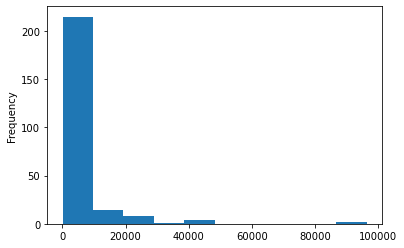

In [49]:
x = df1['statistics.viewCount']
x = x.astype('int')
x[x < 100000].plot.hist()

0       7088
1       7002
2       9081
3     229860
4       5491
       ...  
46      2784
47       331
48       354
49       461
0        250
Name: statistics.viewCount, Length: 250, dtype: int32

In [42]:
df1[df1['statistics.viewCount']==str(x.max())]

,snippet.title,snippet.tags,contentDetails.duration,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.commentCount,snippet.publishedAt
17,"I didn't eat food for 4 days, here's what happ...","[what is like to do an extended fast?, intermi...",PT45M41S,426775,4907,490,934,2019-09-15T12:06:12Z
